# ROMS - Forward tracking

*PyLag* includes support for reading in Rregional Ocean Modelling System (ROMS) outputs and using them to track the movement of particles in the simulated flow field. Here we demonstrate this functionality using outputs from a multi-year numerical simulation of flow and water properties over the Texas-Louisiana contintal shelf. ROMS outputs for the region have been made available via a [public thredds server](http://barataria.tamu.edu/thredds/dodsC/NcML/txla_hindcast_agg.html) that has been set up by the [Physical Oceanography Numerical Group (PONG)](http://pong.tamu.edu/people.html) from [Texas A&M University](https://www.tamu.edu/). For convenience, a small subset of the full dataset has been pulled and uploaded to [google drive](https://drive.google.com/open?id=15UX7Y9JnuLpnPAz700mzmzd917nTClxR) with the other input datasets used when generating PyLag's documentation. If you would like to run the code in this notebook interactively, download the data into a directory of your chooising. By default, the notebook will look for these files in the directory `${HOME}/data/pylag_doc`. To change this, simply update the *data_dir* path below.

In [1]:
# Imports
import os
import numpy as np
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from matplotlib.tri.triangulation import Triangulation
from scipy.spatial import Delaunay
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray

from pylag.processing.ncview import Viewer
from pylag.processing.plot import create_figure, colourmap
from pylag.processing.plot import ArakawaCPlotter

In [2]:
# Root directory for PyLag example input files
data_dir='/home/jcl/data/ROMS_input_data/Texas'

# Keep a copy of the cwd
cwd = os.getcwd()

# Create run directory
simulation_dir = '{}/simulations/roms_texas'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

## Background

The Regional Ocean Modelling System (ROMS) is a free-surface, terrain-following, primitive equation ocean model. In the horizontal, the model employs a structured, curvilinear grid. The grid is a staggered, Arakawa C-grid. In the vertical, the model employs a generalized vertical, terrain-following coordinate system.

On the Arakawa C-grid, u-, v- and w- velocity components are evaluated on cell faces while all active and passive tracers are evaluated at cell centres. While ignoring those variables defined at cell corners, this effectively yields three separate horizontal grids for the U-, V- and rho-points; and two separate vertical grids for rho- and w-points. To handle grids of this type, PyLag contructs three separate horizontal unstructured grids and two separate vertical grids for the purpose of locating particles and interpolating field data at a given particle's location.

The example uses outputs from a high resolution hindcast simulation of the Texas-Louisianna continental shelf region. The hindcast has been run from 1993 through to the present day. More information on the model system along with links to scientific papers can be found [here](http://pong.tamu.edu/research.html). In the example, forward in time particle tracks are created for a short (two day) simulation.

A map of the model domain with the bathymetry shaded is shown below.

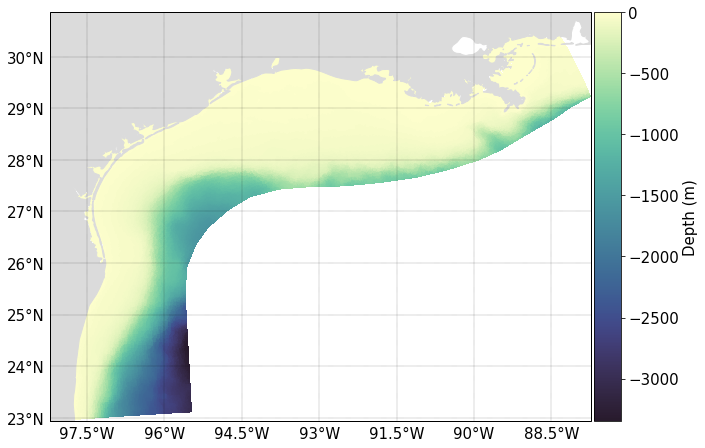

In [7]:
# The name of the grid metrics file
grid_metrics_file_name = '{}/grid_metrics.nc'.format(data_dir)

# Read the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

# Create figure
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='white')

# Configure plotter
plotter = ArakawaCPlotter(grid_metrics_file_name,
                          geospatial_coords=True,
                          font_size=font_size)

# Plot bathymetry
extents = None
ax, plot = plotter.plot_field(ax, 'grid_rho', bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=None, vmax=0., cmap=cmap)

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                            edgecolor='face',
                                            facecolor=cfeature.COLORS['land_alt1']))

When making the above plot, grid information was read in from a [grid metrics](../documentation/overview.ipynb) file, which has been pre-generated for the purpose of running the example.

## Setting particle initial positions

We will create an initial position file in which to record [particle initial positions](../documentation/initial_positions.ipynb). This will be read in by *PyLag* and used to create the initial particle seed. Particles will be released from a single release zone.

In [11]:
import os

from PyFVCOM.coordinate import utm_from_lonlat, lonlat_from_utm
from pylag.processing.release_zone import create_release_zone
from pylag.processing.input import create_initial_positions_file_single_group

# Keep a copy of the cwd
cwd = os.getcwd()

# Create run directory
simulation_dir = '{}/simulations/roms_texas'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# The group ID of this particle set
group_id = 1

# Lat and lon coordiantes for the centre of the release zone
lat = 29.2
lon = -91.8

# Convert to UTM coordinates
easting, northing, zone = utm_from_lonlat([lon], [lat])

# Index into the list to get a string for the zone
zone = zone[0]

# Release zone radius (m)
radius = 10000.0

# Target number of particles to be released. Only a target,
# since we are evenly distributing particles in the release
# zone, which has no unique solution.
n_particles_target = 100

# Release depths
depth_below_surface = 0.0

# Create the release zone
surface_release_zone = create_release_zone(group_id = group_id,
                                           radius = radius,
                                           centre = [easting, northing],
                                           n_particles = n_particles_target,
                                           depth = depth_below_surface,
                                           random = False)

# Get the actual number of particles
n_particles = surface_release_zone.get_number_of_particles()

# Convert to lat/lon coordinates
lons, lats = lonlat_from_utm(surface_release_zone.get_eastings(),
                             surface_release_zone.get_northings(),
                             zone)

# Get depths
depths = surface_release_zone.get_depths()

# Create input sub-directory
input_dir = '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# Output filename
file_name = '{}/initial_positions.dat'.format(input_dir)

# Write data to file
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           lons,
                                           lats,
                                           depths)

To see the initial positions of particles, we can simply plot them. Note the ordered scattering of particles within the circular release zone, which is clearly visibile after zooming in on the release zone.

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f23c6835d90>,
 <matplotlib.collections.PathCollection at 0x7f23c6911450>)

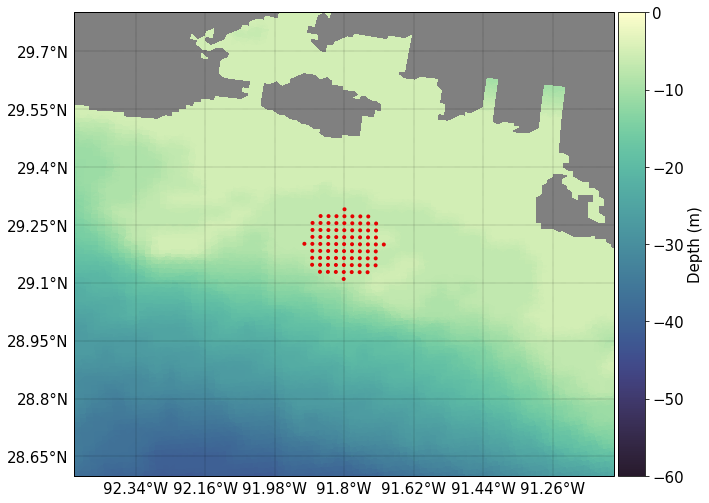

In [44]:
# The name of the grid metrics file
input_dir = '{}/input'.format(simulation_dir)
grid_metrics_file_name = '{}/grid_metrics.nc'.format(input_dir)

# Read the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

# Convert utm coords to degrees
lons, lats = lonlat_from_utm(surface_release_zone.get_eastings(),
                             surface_release_zone.get_northings(),
                             zone='15R')

# Create figure
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Configure plotter
plotter = ArakawaCPlotter(grid_metrics_file_name,
                          geospatial_coords=True,
                          font_size=font_size)

# Plot bathymetry
extents = np.array([-92.5, -91.1, 28.6, 29.8], dtype=float)
ax, plot = plotter.plot_field(ax, 'grid_rho', bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=-60., vmax=0., cmap=cmap)

# Plot particle initial positions
plotter.scatter(ax, 'grid_rho', lons, lats, configure=True, extents=extents, s=16, color='#e50000', edgecolors='none')

## Creating a ROMS grid metrics file

When running with a new input dataset, it is necessary to generate a [grid metrics](../documentation/overview.ipynb) file. The grid metrics file holds information about the grid on which data are defined. *PyLag* reads this file in during model start up. The data is pre-generated, so that the grid information can be reused in later simulations using the same input dataset. This avoids incurring repeated costs associated with generating the data. As stated above, a grid metrics file for this example has been pre-generated; indeed, it was used to create the above plot of the domain's bathymetry. However, for the sake of completeness, we regenerate the grid metrics file so it is clear how this is done in an end-to-end example. To generate a new ROMS grid metrics file, we need an ROMS output file for the domain in question. At a minimum, this should conain the list of dimensions and variables given below. Further assistance on the creation of ROMS grid metrics file can be found in the help pages for the module `pylag.grid_metrics`.

In [ ]:
from pylag.grid_metrics import create_roms_grid_metrics_file

# A ROMS output file
roms_file_name = '{}/txla_hindcast_agg_0001.nc'.format(data_dir)

# Create input sub-directory
input_dir = '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# The name of the output file
grid_metrics_file_name = '{}/grid_metrics.nc'.format(input_dir)

# Provide dimension/variable names
process_grid_u=True
process_grid_v=True
process_grid_rho=True
lon_var_name_grid_u='lon_u'
lat_var_name_grid_u='lat_u'
lon_var_name_grid_v='lon_v'
lat_var_name_grid_v='lat_v'
lon_var_name_grid_rho='lon_rho'
lat_var_name_grid_rho='lat_rho'
xi_dim_name_grid_u='xi_u'
eta_dim_name_grid_u='eta_u'
xi_dim_name_grid_v='xi_v'
eta_dim_name_grid_v='eta_v'
xi_dim_name_grid_rho='xi_rho'
eta_dim_name_grid_rho='eta_rho'
mask_name_grid_u=None
mask_name_grid_v=None
mask_name_grid_rho='mask_rho'
bathymetry_var_name='h'
vtransform=2

# Generate the file
create_roms_grid_metrics_file(roms_file_name,
                              process_grid_u,
                              process_grid_v,
                              process_grid_rho,
                              lon_var_name_grid_u,
                              lat_var_name_grid_u,
                              lon_var_name_grid_v,
                              lat_var_name_grid_v,
                              lon_var_name_grid_rho,
                              lat_var_name_grid_rho,
                              xi_dim_name_grid_u,
                              eta_dim_name_grid_u,
                              xi_dim_name_grid_v,
                              eta_dim_name_grid_v,
                              xi_dim_name_grid_rho,
                              eta_dim_name_grid_rho,
                              mask_name_grid_u,
                              mask_name_grid_v,
                              mask_name_grid_rho,
                              bathymetry_var_name,
                              grid_metrics_file_name,
                              vtransform=vtransform)

## Creating the run configuration file

As in the other examples, a template [run configuration](../documentation/configuration.ipynb) file has been provided. We will use configparser to look at some settings specific to the example. First, we read in the file, then we print out some of the key options for the run:

In [33]:
import configparser

config_file_name = './configs/roms_txla_template.cfg'

cf = configparser.ConfigParser()
cf.read(config_file_name)

# Start time
print('Start time: {}'.format(cf.get('SIMULATION', 'start_datetime')))

# End time
print('End time: {}'.format(cf.get('SIMULATION', 'end_datetime')))

# Specify that this is a forward tracking experiment
print('Time direction: {}'.format(cf.get('SIMULATION', 'time_direction')))

# We will do a single run, rather than an ensemble run
print('Number of particle releases: {}'.format(cf.get('SIMULATION', 'number_of_particle_releases')))

# Use depth restoring, and restore particle depths to the ocean surface
print('Use depth restoring: {}'.format(cf.get('SIMULATION', 'depth_restoring')))
print('Restore particles to a depth of: {} m'.format(cf.get('SIMULATION', 'fixed_depth')))

# Specify that we are working with Arakawa A-grid in spherical coordinates
print('Model name: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'name')))
print('Coordinate system: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'coordinate_system')))

# Set the location of the grid metrics and input files
print('Data directory: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'data_dir')))
print('Path to grid metrics file: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file')))
print('File name stem of input files: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'data_file_stem')))

Start time: 2018-06-29 00:00:00
End time: 2018-06-30 23:00:00
Time direction: forward
Number of particle releases: 1
Use depth restoring: True
Restore particles to a depth of: 0.0 m
Model name: ROMS
Coordinate system: spherical
Data directory: 
Path to grid metrics file: 
File name stem of input files: txla_


From the above options, it can be seen we hvae not yet specified a directory within which the model can find ROMS output files, or the location of the grid metrics file. We will set these using `data_dir`, and save the new config file in the simulation directory. All other paths are relative, and can be left as they are.

In [34]:
cf.set('OCEAN_CIRCULATION_MODEL', 'data_dir', data_dir)
cf.set('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file', grid_metrics_file_name)

# Save a copy in the simulation directory
with open("{}/pylag.cfg".format(simulation_dir), 'w') as config:
    cf.write(config)

## Running the model

With the run configuration file saved, we can now run the example. While PyLag can be used interactivatly, it is most commonly launched from the command line. A small driver script has been provided, which we will use here to launch *PyLag*.

In [35]:
import subprocess

# Change to the run directory and launch
os.chdir('{}'.format(simulation_dir))

try:
    subprocess.call(['./run.sh'])
except:
    print('Run failed.')
    pass

# Return to the cwd
os.chdir(cwd)

## Visualising the result

With the model having run, the final step is to visulise the result. Here, we first produce an animation of the velocity field over the course of the simulation. Then we plot particle pathlines.

Sorting axes for variable u
Sorting axes for variable v
(30, 127970)
(30, 127490)


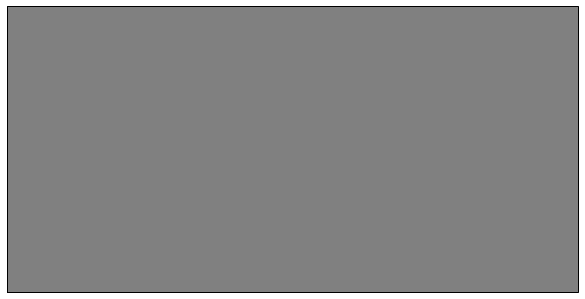

In [8]:
from datetime import timedelta

from pylag.grid_metrics import sort_axes
from pylag.processing.ncview import Viewer


# Dataset holding ROMS input data
roms_input_data = '{}/txla_hindcast_agg_0001.nc'.format(data_dir)
roms_viewer = Viewer(roms_input_data, time_rounding=3600)

# Dataset holding PyLag ouputs
file_name = '{}/output/pylag_1.nc'.format(simulation_dir)
pylag_viewer = Viewer(file_name, time_rounding=900)

# u and v velocity components
u = sort_axes(roms_viewer('u'), 'ocean_time', 's_rho', 'eta_u', 'xi_u')
v = sort_axes(roms_viewer('v'), 'ocean_time', 's_rho', 'eta_v', 'xi_v')

# Create plot
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Configure plotter
plotter = ArakawaCPlotter(grid_metrics_file_name,
                          geospatial_coords=True,
                          font_size=font_size)

# Plot bathymetry
#extents = np.array([-92.5, -91.0, 28.5, 29.5], dtype=float)
#ax, plot = plotter.plot_field(ax, 'grid_rho', bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
#                              vmin=-60., vmax=0., cmap=cmap)

# Draw velocity field
date = pylag_viewer.date[0]
roms_time_index = roms_dates.tolist().index(date)

# Reshape u
_u = u[roms_time_index, :]
_u = _u.reshape(_u.shape[0], np.prod(_u.shape[1:]))

# Reshape v
_v = v[roms_time_index, :]
_v = _v.reshape(_v.shape[0], np.prod(_v.shape[1:]))

print(_u.shape)
print(_v.shape)
# Plot quiver
#axes.quiver(self._xc, self._yc, _u, _v, units='inches', scale_units='inches', scale=scale)

# Time of flight
#time_of_flight = timedelta(hours=46)

#self.axes.quiver(self._xc, self._yc, u, v, units='inches', scale_units='inches', scale=scale)


# Dataset holding particle positions


# Plot particle final positions
#x, scatter = plotter.scatter(ax, 'grid_rho', viewer('longitude')[time_index, :].squeeze(),
#                    viewer('latitude')[time_index, :].squeeze(),
#                    s=8, color='#e50000', edgecolors='none')

# Add path lines
#ax, lines = plotter.plot_lines(ax, viewer('longitude')[:time_index, :],
#                               viewer('latitude')[:time_index, :],
#                               linewidth=0.15, alpha=1,
#                               color='#0504aa')


#pylag_dates = viewer.date[0] + time_of_flight
#time_index = viewer.date.tolist().index(date)